# Data analyzing with Yelp API
Yelp API allows us to get local content and user review from millions of businesses across 32 countries. Recorded businesses in Yelp database vary from services such as plumber, vehicle repair, restaurant...

From Yelp API, following information can be extracted:
- Business Endpoint:
    - Business Search: this endpoint return up to 1000 businesses based on the provided search criteria.
    - Phone Search: This endpoint returns a list of businesses based on the provided phone number.
    - Transaction Search: This endpoint returns a list of businesses which support food delivery transactions.
    - Business Details: This endpoint returns detailed business content based on business's id which can extract with business search endpoint.
    - Business Match: This endpoint lets you match business data from other sources against businesses on Yelp, based on provided business information.
    - Reviews: This endpoint returns all review of business based on business's id.
    - Auto complete: This endpoint returns auto complete suggestions for search keywords, businesses and categories, based on the input text.
- Event Endpoint:
    - Event Lookup: This endpoint returns the detailed information of a Yelp event
    - Event Search: This endpoint returns events based on the provided search criteria.
    - Featured event: This endpoint returns the featured event for a given location. Featured events are chosen by Yelp's community managers.
- Category Endpoint:
    - All categories: This endpoint returns all Yelp business categories across all locales by default.
    - Category details: This endpoint returns detailed information about the Yelp category specified by a Yelp category alias.
    
In this work, I will focus on all restaurants which are registered in Yelp's database across Finland.

In [1]:
import requests
import json
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import regex as re
import time
import glob
import os
import ast
from fuzzywuzzy import process

import folium 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from ipywidgets import interact
import plotly.graph_objects as go
import chart_studio.plotly as py
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

init_notebook_mode(connected=True)
cf.go_offline(connected=True)
cf.set_config_file(theme="pearl")
pd.set_option('display.max_columns', 30)
%matplotlib inline

# Gathering data
## Getting all city of Finland

To retrieve all the information of restaurant within Finland, and since Yelp API limits the result at 1,000 based on the provided search criteria, I decide the search criteria should be city of Finland instead of Finland, to get as many result as possible. Therefore, first I try to get all the city of Finland.

The information about Finnish cities can be easily found on wikipedia on this link: https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Finland

Since there are only 107 cities in Finland, it is easy to just copy and paste the whole list of city. However, to implement for future projects that can contain thousands of entities, I will use web scrapping to get the table content in the page.

In [2]:
url_city = 'https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Finland'
page = requests.get(url_city).text
soup = BeautifulSoup(page, "lxml")

There also some notation, further explanation in some variable and in this project, the only information we take into account is the name of city and its population, I will remove those. The notations and explanation are basically in form of [character], therefore, I make a simple function to remove them with regex.

In [3]:
def removeNote(string):
    return re.sub("\[[^[]]*\]", "", string)

In [4]:
table = soup.find("table", attrs={"class":"wikitable"})
table_head = table.find_all("th")
headings = []
for th in table_head:
    headings.append(removeNote(th.text.replace("\n"," ").strip()))    

In [5]:
table_content = []
for tr in table.tbody.find_all("tr"):
    table_row = {}
    for td, th in zip(tr.find_all("td"), headings):
        table_row[th]= removeNote(td.text.replace("\n"," ").strip())
    table_content.append(table_row)
cities = pd.DataFrame(table_content[1:])
cities.head()

,Finnish name,Swedish name,District,Founded,Population
0,Akaa,,,2007,"16,709"
1,Alajärvi,,,1986,"9,752"
2,Alavus,,,1977,"11,611"
3,Espoo,Esbo,Helsinki,1972,"281,866"
4,Forssa,,,1964,"17,079"


## Getting data with Yelp API
### Business detail

To get business detail, I will use business endpoint provided by Yelp API.

In [6]:
with open("key.txt") as file:
    client = file.readline()[:-1]
    key = file.readline()

In [7]:
url_search = "https://api.yelp.com/v3/businesses/search"
headers = {'Authorization': f'Bearer {key}'}

Yelp API have limitation request of 5000 per day, therefore, I will request all the information I need and write them to my local machine for working later without requesting everything over again.

In [8]:
# for city in cities["Finnish name"]:
#     time.sleep(10)
#     df = pd.DataFrame()
#     for i in range(0,1000,50):
#         querry_string_search = {"term": "restaurant", "location": f'{city} Finland', 'limit':50, 'offset':i}
#         response = requests.get(url_search, params= querry_string_search, headers=headers)
#         if response.status_code != 200:
#             break
#         restaurants = pd.json_normalize((response.json()["businesses"]))
#         df = pd.concat([df, restaurants], ignore_index=True)
#     df.to_csv(f"data/{city}.csv")

In [9]:
glob.glob(os.path.join("data/*.csv"))

['data\\Akaa.csv',
 'data\\Alajärvi.csv',
 'data\\Alavus.csv',
 'data\\all_restaurants.csv',
 'data\\Espoo.csv',
 'data\\Forssa.csv',
 'data\\Haapajärvi.csv',
 'data\\Haapavesi.csv',
 'data\\Hamina.csv',
 'data\\Hanko.csv',
 'data\\Harjavalta.csv',
 'data\\Heinola.csv',
 'data\\Helsinki.csv',
 'data\\Huittinen.csv',
 'data\\Hyvinkää.csv',
 'data\\Hämeenlinna.csv',
 'data\\Iisalmi.csv',
 'data\\Ikaalinen.csv',
 'data\\Imatra.csv',
 'data\\Joensuu.csv',
 'data\\Jyväskylä.csv',
 'data\\Jämsä.csv',
 'data\\Järvenpää.csv',
 'data\\Kaarina.csv',
 'data\\Kajaani.csv',
 'data\\Kalajoki.csv',
 'data\\Kangasala.csv',
 'data\\Kankaanpää.csv',
 'data\\Kannus.csv',
 'data\\Karkkila.csv',
 'data\\Kaskinen.csv',
 'data\\Kauhajoki.csv',
 'data\\Kauhava.csv',
 'data\\Kauniainen.csv',
 'data\\Kemi.csv',
 'data\\Kemijärvi.csv',
 'data\\Kerava.csv',
 'data\\Keuruu.csv',
 'data\\Kitee.csv',
 'data\\Kiuruvesi.csv',
 'data\\Kokemäki.csv',
 'data\\Kokkola.csv',
 'data\\Kotka.csv',
 'data\\Kouvola.csv',
 'data

Among these file, there are some empty files that will trouble the further reading data, therefore, I will remove those files. The list of empty file could be found below:

In [10]:
for file in glob.glob(os.path.join("data/*.csv")):
    if pd.read_csv(file).empty:
        print(file, "has no recorded business")

data\Haapavesi.csv has no recorded business
data\Hyvinkää.csv has no recorded business
data\Kitee.csv has no recorded business
data\Nivala.csv has no recorded business
data\Nurmes.csv has no recorded business
data\Pudasjärvi.csv has no recorded business


In [11]:
# Create a list of file that contains non-empty file only

list_file = [file for file in glob.glob(os.path.join("data/*.csv")) if not pd.read_csv(file).empty]

Besides above problem, there is another, there are some files that are in different format, for specific, they have only 24 columns while other have 25. The information about the price level of that business is missing.

In [12]:
for file in list_file:
    if pd.read_csv(file).shape[1]!=25:
        print(file, pd.read_csv(file).shape)

data\Haapajärvi.csv (2, 24)
data\Kalajoki.csv (5, 24)
data\Kemijärvi.csv (2, 24)
data\Kuhmo.csv (1, 24)
data\Lieksa.csv (1, 24)
data\Oulainen.csv (2, 24)
data\Pyhäjärvi.csv (1, 24)
data\reviews1.csv (3, 10)
data\Saarijärvi.csv (1, 24)
data\Viitasaari.csv (1, 24)
data\Ylivieska.csv (5, 24)
data\Ähtäri.csv (3, 24)


We can see that in these cities, there are fewer than 5 business recorded in Yelp's database. To simplify the process, these files will also be dropped.

In [13]:
final_list_file = [file for file in list_file if pd.read_csv(file).shape[1]==25]

### Loading data into dataframe

All the data can now be concatenating to dataframe. However, before concatenating, the same order of columns of all the file should be the same to avoid any mistake in analyzing later on. right order.

Since, every data file has the same columns, I will take column order of the first file "Akaa.csv" to be the standard and apply this order on other files.

In [14]:
# Take columns order of Akaa.csv dataset
col_order = pd.read_csv("data/Akaa.csv", index_col=0).columns

In [15]:
# Concatenate other dataset based on premade column order

data = pd.DataFrame()
for file in final_list_file:
    df_file = pd.read_csv(file, index_col=0)[col_order]
    data = pd.concat([data, df_file], ignore_index=True)

Now we have a dataframe that contains all restaurant in Finland. And I will turn this dataframe content to csv format file to avoid repeating all the steps again.

In [16]:
#data.to_csv("all_restaurants.csv")

### Reviews for businesses

Beside the business details, I also want to retrieve reviews of every restaurant in Finland, however, Yelp's API only allows to extract 3 top reviews each business and mostly, these reviews are only good ones. Besides, the content of the reviews extracted from Yelp's API only contain a part of the whole review, therefore, at the moment, the review analyzing are not doable with Yelp's API.

In [17]:
url_review = "https://api.yelp.com/v3/businesses/"
headers = {'Authorization': f'Bearer {key}'}

In [18]:
df = pd.read_csv("all_restaurants.csv",index_col=0)
a = df.loc[df["review_count"].idxmax()].id

In [19]:
reviews_en = pd.DataFrame()
respone_en = requests.get(url_review+a+'/reviews', params={"locale":"en_US"}, headers=headers)
reviews_en = pd.json_normalize((respone_en.json()["reviews"]))
reviews_en

,id,url,text,rating,time_created,user.id,user.profile_url,user.image_url,user.name
0,0g2w3eKg715QE5ddkjH05A,https://www.yelp.com/biz/karl-fazer-caf%C3%A9-...,UGHHHH. This is a love/hate situation. Our t...,5,2019-07-26 11:24:47,7vCCPqR9cJoy_AY0BkdyUg,https://www.yelp.com/user_details?userid=7vCCP...,https://s3-media2.fl.yelpcdn.com/photo/dO1LlTi...,Savanna M.
1,Qe7iC0CWQdIPrVL_zCjXjg,https://www.yelp.com/biz/karl-fazer-caf%C3%A9-...,"I came in for a coffee and a pastry, as is app...",5,2019-11-15 08:07:52,TaR1SQ0whb0keyXbPTNwTA,https://www.yelp.com/user_details?userid=TaR1S...,https://s3-media1.fl.yelpcdn.com/photo/RLtgOw1...,Alesa W.
2,eu-qdiDqV_BLYGfFi2aaOg,https://www.yelp.com/biz/karl-fazer-caf%C3%A9-...,Right in front of the hotel I was staying at i...,5,2018-12-12 06:04:13,tH0uKD-vNwMoEc3Xk3Cbdg,https://www.yelp.com/user_details?userid=tH0uK...,https://s3-media2.fl.yelpcdn.com/photo/QMKcdO-...,Cathy C.


In [20]:
reviews_en.text[0]

'UGHHHH.  This is a love/hate situation.  Our tour guide in St. Petersberg told us that we just had to try some Fazer chocolate while in Helsinki.  Ok noted,...'

In [21]:
reviews_fi = pd.DataFrame()
respone_fi = requests.get(url_review+a+'/reviews', params={"locale":"fi_FI"}, headers=headers)
reviews_fi = pd.json_normalize((respone_fi.json()["reviews"]))
reviews_fi

,id,url,text,rating,time_created,user.id,user.profile_url,user.image_url,user.name
0,p36H2kpiQfDKQdJRWolEeg,https://www.yelp.com/biz/karl-fazer-caf%C3%A9-...,Jos kaipaa perinteitä ja historiallista funkki...,5,2014-05-21 01:48:02,ALLjAO0DitH59HUq6d4lnw,https://www.yelp.com/user_details?userid=ALLjA...,https://s3-media2.fl.yelpcdn.com/photo/gH2O8ub...,Veera T.
1,7HUOui_nU636sZytxxRxZQ,https://www.yelp.com/biz/karl-fazer-caf%C3%A9-...,Kyseessä on keskustan yksi parhaimmista klassi...,5,2019-03-14 13:18:32,oQlPbuhWGPpoeSRF2sPSoQ,https://www.yelp.com/user_details?userid=oQlPb...,None,Dank T.
2,eO0NEOW8mEC64cw89XnaFw,https://www.yelp.com/biz/karl-fazer-caf%C3%A9-...,Kluuvikadun legendaarinen Karl Fazer Cafe on a...,4,2014-11-27 14:40:39,ATNVRZWUxp613GiHGsoA8A,https://www.yelp.com/user_details?userid=ATNVR...,https://s3-media1.fl.yelpcdn.com/photo/laCPggs...,Hanna B.


In [22]:
reviews_fi.text[2]

'Kluuvikadun legendaarinen Karl Fazer Cafe on arkkitehtuurisesti näyttävä ja historiallisesti merkittävä kahvila. Kyseinen paikka on palvellut...'

# Data analyzing
## Data description

After retrieving all necessary data from API, we now have 2 dataframe:
- City: which includes:
    - City name in Finnish,and Swedish
    - District
    - Foundation date
    - Population
- Restaurant will include:
    - business id
    - alias and name
    - image link
    - status of open or close
    - url on Yelp's database
    - number of review
    - category of the business
    - rating
    - transaction type
    - price level
    - phone number
    - coordinate
    - address, location, zip code

## Data cleaning
### Remove unnecessary columns

In [23]:
df = pd.read_csv("all_restaurants.csv",index_col=0)

In [24]:
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,phone,display_phone,distance,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address
0,beGLUbmL35UJDqWGfsS9JA,popino-hameenlinna,Popino,https://s3-media2.fl.yelpcdn.com/bphoto/69ILMz...,False,https://www.yelp.com/biz/popino-hameenlinna?ad...,4,"[{'alias': 'restaurants', 'title': 'Restaurant...",4.5,[],€€,35836532555.0,+358 3 6532555,37454.613324,60.996349,24.467030,Raatihuoneenkatu 11,NaN,NaN,Hameenlinna,13100.0,FI,6.0,"['Raatihuoneenkatu 11', '13100 Hameenlinna', '..."
1,C2tL1QG2GE3LymV2L_y4zQ,vaihmalan-hovi-lempäälä,Vaihmalan Hovi,https://s3-media2.fl.yelpcdn.com/bphoto/13cgVD...,False,https://www.yelp.com/biz/vaihmalan-hovi-lemp%C...,1,"[{'alias': 'restaurants', 'title': 'Restaurant...",4.0,[],€€€,358207661810.0,+358 20 7661810,15118.429192,61.297451,23.777439,Vaihmalantie 144,NaN,NaN,Lempäälä,37500.0,FI,11.0,"['Vaihmalantie 144', '37500 Lempäälä', 'Finland']"
2,Ub6jAwhYnGRR5ET-llUFeQ,iittalan-lasikeskus-hämeenlinna,Iittalan Lasikeskus,NaN,False,https://www.yelp.com/biz/iittalan-lasikeskus-h...,1,"[{'alias': 'restaurants', 'title': 'Restaurant...",4.0,[],NaN,NaN,NaN,16368.838825,61.086704,24.121902,Kyyhkysentie 7,NaN,NaN,Hämeenlinna,14500.0,FI,6.0,"['Kyyhkysentie 7', '14500 Hämeenlinna', 'Finla..."
3,ar8dwagEYyS7zTyqaIbrEg,sawaddee-hämeenlinna,Sawaddee,https://s3-media1.fl.yelpcdn.com/bphoto/Nc8jde...,False,https://www.yelp.com/biz/sawaddee-h%C3%A4meenl...,3,"[{'alias': 'thai', 'title': 'Thai'}]",4.0,[],€€,358440737007.0,+358 44 0737007,37198.075417,60.997372,24.462761,Sibeliuksenkatu 13,NaN,NaN,Hämeenlinna,13100.0,FI,6.0,"['Sibeliuksenkatu 13', '13100 Hämeenlinna', 'F..."
4,EyVADV5l8DyWv5JNo_9cuA,fresno-hämeenlinna,Fresno,https://s3-media1.fl.yelpcdn.com/bphoto/g68yp-...,False,https://www.yelp.com/biz/fresno-h%C3%A4meenlin...,3,"[{'alias': 'tradamerican', 'title': 'American ...",4.0,[],€€,358452351012.0,+358 45 2351012,37256.582366,60.996840,24.463374,Hallituskatu 20,NaN,NaN,Hämeenlinna,13100.0,FI,6.0,"['Hallituskatu 20', '13100 Hämeenlinna', 'Finl..."


Firstly, these columns will be removed since, they don't provide any analytical value:
- id: since every business has its own unique id.
- alias: Unique Yelp alias of this business.
- image_url: URL of photo for this business.
- url: URL for business page on Yelp.
- phone and display phone
- location.display_address: since we have separated columns for every information contains in this column.

In [25]:
df.drop(["id", "alias", "image_url", "url", "phone", "display_phone", "location.display_address"], axis=1, inplace=True)

Examine more closely, the is_close column, which indicates if the business is closed permanently or not, only contains False value, which mean that every business listed in this dataframe is still operating. Therefore, this column will be dropped.

In [26]:
df.is_closed.unique()

array([False])

In [27]:
df.drop("is_closed", axis=1, inplace=True)

The transactions column, that should display the list of Yelp transactions that the business is registered for, however, only contain empty list. Therefore, it will be dropped, too.

In [28]:
all(df.transactions=="[]")

True

In [29]:
df.drop("transactions", axis=1, inplace=True)

For a business, its location detail contain 3 columns of address. 
- The first one is address of business based on the mall/location name or if it is not in a mall, this column will contain the street address in Finnish.
- The second one is the street address in Finish if the previous information is mall/location name. Otherwise, it contains street address in Swedish if the previous ones is street address in Finish.
- The last one is mostly NaN value or name of the city that this business locates.

Since we have specified column "location.city", and the column "location.address1" has sufficient information about the address, we can drop the other two columns. The location.address1 column will also be renamed to "address" for simplification.

In [30]:
df.drop(["location.address2", "location.address3"], axis=1, inplace=True)
df.rename({"location.address1": "address"}, axis=1, inplace=True)

"location.state" column also can be dropped since we have city name for reference.

In [31]:
df.drop("location.state", axis=1, inplace=True)

### Rename columns and reformat the contain
Rename to columns to decrease the length for simplification.

In [32]:
df.rename({"coordinates.latitude":"lat", "coordinates.longitude":"long", "location.city":"city", "location.zip_code": "zipcode", 
           "location.country": "country"}, axis=1, inplace=True)

To make sure that the text contains are in the same format for later duplicates checking, I will apply the same type of format title for three columns: 
- name
- address
- city

In [33]:
df[['name', 'address', 'city']] = df[['name', 'address', 'city']].apply(lambda x: x.str.title(), axis=1)

I check further for any mistakes in recording city name. For example, city name should be in Finnish not Swedish.

In [34]:
swedish_name = list(set([city for city in df.city if city in cities["Swedish name"].to_list()]))
swedish_name

['Mariehamn', 'Helsingfors', 'Jakobstad']

We can see that there are some entries that record the city information in Swedish instead of Finnish, and their correct name in Finnish is:

In [35]:
d = {}
for city in swedish_name:
    d[city] = cities[cities["Swedish name"]==city]["Finnish name"].values[0]
d

{'Mariehamn': 'Maarianhamina',
 'Helsingfors': 'Helsinki',
 'Jakobstad': 'Pietarsaari'}

They will be changed to Finnish name now.

In [36]:
df.city = df.city.apply(lambda x: d[x] if x in d.keys() else x)

Another problem I detected during the data cleaning is that there are some restaurants that are not in Finnish region.

In [37]:
df.country.unique()

array(['FI', 'DE', 'SE', 'IT'], dtype=object)

Therefore, these rows will be removed. After making sure all the restaurants are in Finland, we can drop the country column.

In [38]:
df = df[df.country=='FI'].drop("country", axis=1)

Finally, since Finnish alphabet have some special letter, that could be replace with English alphabet, I will check for the similarity of city name to find if there is any mistake.

In [39]:
ori_city = df.city.unique()
for i in range(len(ori_city)-1):
    base = ori_city[i]
    to_check = ori_city[i+1:]
    ratios = process.extractOne(base, to_check)
    if ratios[1] > 85:
        print(base, ratios)

Hameenlinna ('Hämeenlinna', 95)
Salo ('Oulunsalo', 90)
Hamina ('Maarianhamina', 90)
Virolahti ('Lahti', 90)
Pori ('Raasepori', 90)
Säkylä ('Jyväskylä', 90)
Kontiolahti ('Lahti', 90)
Jyväskylä ('Jyvaskyla', 88)
Jämsänkoski ('Jämsä', 90)
Korpilahti ('Lahti', 90)
Kemi ('Kemiö', 100)
Pohjaslahti ('Lahti', 90)
Fiskars ('Fiskari', 86)
Oulu ('Oulunsalo', 90)
Napapiiri Rovaniemi ('Rovaniemi', 90)


We can see that Hämeenlinna is replaced with Hameenlinna and Jyväskylä is replaced with Jyvaskyla. I will replace these name with their right one. Other names that have high similarity, they are town near the city, therefore, no need to change.

In [40]:
right_name = {"Hameenlinna": "Hämeenlinna", "Jyvaskyla": "Jyväskylä"}
df.city = df.city.apply(lambda x: right_name[x] if x in right_name.keys() else x)

### Modify the type of columns & check for duplicates

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4650 entries, 0 to 4662
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          4650 non-null   object 
 1   review_count  4650 non-null   int64  
 2   categories    4650 non-null   object 
 3   rating        4650 non-null   float64
 4   price         2330 non-null   object 
 5   distance      4650 non-null   float64
 6   lat           4650 non-null   float64
 7   long          4650 non-null   float64
 8   address       4637 non-null   object 
 9   city          4650 non-null   object 
 10  zipcode       4630 non-null   object 
dtypes: float64(4), int64(1), object(6)
memory usage: 435.9+ KB


Every column is in correct type, so there is nothing to modify on the type of column. Let's check for duplicates. For this check, "name","address","lat","long",and "city" columns will be included in subset for checking.

In [42]:
df.duplicated(subset=["name","address","lat","long","city"]).sum()

2421

In [43]:
df.drop_duplicates(subset=["name","address","lat","long","city"], inplace=True)

### Dealing with NaN values

In [44]:
df.isnull().sum()

name               0
review_count       0
categories         0
rating             0
price           1017
distance           0
lat                0
long               0
address            9
city               0
zipcode            9
dtype: int64

<AxesSubplot:>

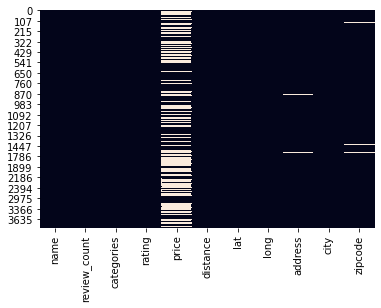

In [45]:
sns.heatmap(df.isnull(), cbar=False)

Mostly all the missing values are in price level columns.It can be examined further to find a suitable method to deal with these missing values.

In [46]:
price = df["price"].isnull().groupby(df["city"]).sum().sort_values()
price_city = df.groupby("city").count()["name"].sort_values()
c_pie = pd.Series(index = ["other"], data = [price_city[price_city<50].sum()]).append(price_city[price_city>=50])

In [47]:
px.pie(c_pie, values=c_pie.values, names=c_pie.index,title = "Proportion for each city in dataset")

In [48]:
d = (price*100/price_city)
e = (d[["Helsinki","Tampere","Espoo","Vantaa","Turku", "Oulu"]]).append(pd.Series(index = ["other"], data= d[[city for city in d.index if city not in ["Helsinki","Tampere","Espoo","Vantaa","Turku", "Oulu"]]].mean()))

In [49]:
e.iplot(kind="bar", title="Percentage of missing value on the basic of city")

In [50]:
null_city = pd.concat([price,price_city], axis=1).rename({"price":"number of missing value", "name":"number of restaurant"}, axis=1).T
null_city = null_city.reindex(sorted(null_city.columns), axis=1)

In [51]:
def null_of_city(city):
    fig = null_city[city].iplot(kind = 'bar', layout = dict(title = f'Null value of {city}'))

In [52]:
interact(null_of_city, city = null_city.columns)

interactive(children=(Dropdown(description='city', options=('Alavus', 'Dalsbruk', 'Ekenäs', 'Eräjärvi', 'Espoo…

<function __main__.null_of_city(city)>

My first attempt is to fill the missing values for famous and well-known branches such as Mc Donald, Espresso House... if any of entry with that name miss the price level information. However, the Yelp API doesn't work as I expect or the database is not big enough, therefore, even for those famous branches, only few results were returned. For example:

In [53]:
df[df.name=="Espresso House"]

,name,review_count,categories,rating,price,distance,lat,long,address,city,zipcode
389,Espresso House,1,"[{'alias': 'cafeteria', 'title': 'Cafeteria'}]",4.0,NaN,7602.150327,60.21813,24.81281,Leppävaarankatu 3-9,Espoo,2600.0


There is only one result of Espresso House for all city in Finland and it doesn't make sense.

Since this columns is an important aspect to analyze, I decide to keep the columns instead of dropping it. Therefore, the row with NaN values will be removed.

The remaining missing values amount in address and zipcode is small and insignificant to the dataset, therefore, they will be dropped too.

In [54]:
df.dropna(inplace=True)

After removing all the missing values, we can re-format the content of price column to numeric for later analyzing. 

In [55]:
df.price = df.price.apply(lambda x: len(x))

In [56]:
df.head()

,name,review_count,categories,rating,price,distance,lat,long,address,city,zipcode
0,Popino,4,"[{'alias': 'restaurants', 'title': 'Restaurant...",4.5,2,37454.613324,60.996349,24.467030,Raatihuoneenkatu 11,Hämeenlinna,13100.0
1,Vaihmalan Hovi,1,"[{'alias': 'restaurants', 'title': 'Restaurant...",4.0,3,15118.429192,61.297451,23.777439,Vaihmalantie 144,Lempäälä,37500.0
3,Sawaddee,3,"[{'alias': 'thai', 'title': 'Thai'}]",4.0,2,37198.075417,60.997372,24.462761,Sibeliuksenkatu 13,Hämeenlinna,13100.0
4,Fresno,3,"[{'alias': 'tradamerican', 'title': 'American ...",4.0,2,37256.582366,60.996840,24.463374,Hallituskatu 20,Hämeenlinna,13100.0
5,Tuulensuu,8,"[{'alias': 'gastropubs', 'title': 'Gastropubs'}]",4.0,2,37347.573733,61.498600,23.753660,Hämeenpuisto 23,Tampere,33210.0


In [57]:
df.shape

(1203, 11)

The dataset now includes 1203 entries and 11 columns. And the price column is in numeric format.
### Modify categories columns

Currently, the data in categories column is in object type, therefore, we first have to convert them into list type before processing.

In [58]:
df.categories = df.categories.apply(ast.literal_eval)
df.categories[1442]

[{'alias': 'danceclubs', 'title': 'Dance Clubs'},
 {'alias': 'musicvenues', 'title': 'Music Venues'},
 {'alias': 'movietheaters', 'title': 'Cinema'},
 {'alias': 'restaurants', 'title': 'Restaurants'}]

To expand all the information in the categories column, first we have to check if there is any empty list among the values.

In [59]:
df.categories.apply(lambda x: len(x)).value_counts()

1    621
2    457
3    123
4      1
0      1
Name: categories, dtype: int64

In [60]:
df.loc[df.categories.apply(lambda x: len(x)).idxmin()]

name                             Inez
review_count                        1
categories                         []
rating                              5
price                               2
distance                      37239.6
lat                           61.4991
long                          23.7669
address         Pellavatehtaankatu 19
city                          Tampere
zipcode                       33100.0
Name: 22, dtype: object

Since all the result retrieved belongs to restaurant category, therefore, we can fill this missing data instead of removing the row.

In [61]:
df.loc[22, "categories"] = [{'alias': 'restaurants', 'title': 'Restaurants'}]

Now, with no missing value, we can construct a dataframe for the category.

In [62]:
category = pd.DataFrame(columns=[0,1,2,3])
for ind, value in zip(df.categories.index, df.categories.values):
    val = pd.DataFrame(value, index=np.arange(len(value))).title.values
    category.loc[ind, np.arange(len(val))] = val

In [63]:
category.head(10)

,0,1,2,3
0,Restaurants,NaN,NaN,NaN
1,Restaurants,NaN,NaN,NaN
3,Thai,NaN,NaN,NaN
4,American (Traditional),NaN,NaN,NaN
5,Gastropubs,NaN,NaN,NaN
6,Lebanese,Vegetarian,NaN,NaN
7,Scandinavian,Buffets,Comfort Food,NaN
8,Music Venues,Venues & Event Spaces,Burgers,NaN
10,Malaysian,NaN,NaN,NaN
11,Scandinavian,NaN,NaN,NaN


My first idea of processing this data is to divide them into different categories:
- Region: Asian, American, Scandinavian...
- Type: Fast Food, Buffet...

However the data in this dataframe is quite mixed up and my only solution for sorting out this kind of data is doing manually, therefore, I postpone this idea for now. Instead I will combine all the string of each entry together and replace the original column with this.

In [64]:
df1 = pd.concat([df, category.fillna("").apply(lambda x: x.str.cat(sep=" ").strip(), axis=1)], axis=1)
df = df1.drop("categories", axis=1).rename({0:"category"}, axis =1)

In [65]:
df.head()

,name,review_count,rating,price,distance,lat,long,address,city,zipcode,category
0,Popino,4,4.5,2,37454.613324,60.996349,24.467030,Raatihuoneenkatu 11,Hämeenlinna,13100.0,Restaurants
1,Vaihmalan Hovi,1,4.0,3,15118.429192,61.297451,23.777439,Vaihmalantie 144,Lempäälä,37500.0,Restaurants
3,Sawaddee,3,4.0,2,37198.075417,60.997372,24.462761,Sibeliuksenkatu 13,Hämeenlinna,13100.0,Thai
4,Fresno,3,4.0,2,37256.582366,60.996840,24.463374,Hallituskatu 20,Hämeenlinna,13100.0,American (Traditional)
5,Tuulensuu,8,4.0,2,37347.573733,61.498600,23.753660,Hämeenpuisto 23,Tampere,33210.0,Gastropubs


## Analyzing

### Density of restaurant for each city

In [66]:
def restaurant_map(city):
    if city in df["city"].unique():
        ci = df[df["city"]==city]
        pos = ci[ci.distance==ci.distance.min()][["lat", "long"]]
        a_map = folium.Map(location=[pos.lat.values[0], pos.long.values[0]],
                         tiles='cartodbpositron',
                          zoom_start=12,)
        ci.apply(lambda row: folium.CircleMarker(location = [row.lat, row.long], radius=3).add_to(a_map), axis=1)
    else:
        a_map = folium.Map(location=[63.4500229, 25.464308],
                         tiles='cartodbpositron',
                          zoom_start=5,)
        df.apply(lambda row: folium.CircleMarker(location = [row.lat, row.long], radius=3).add_to(a_map), axis=1)
    return a_map

In [67]:
interact(restaurant_map, city=sorted(np.append(df.city.unique(),["All"])))

interactive(children=(Dropdown(description='city', options=('All', 'Ekenäs', 'Espoo', 'Fiskari', 'Hanko', 'Hei…

<function __main__.restaurant_map(city)>

The density of restaurant is increasing toward the South, and since the population is different from city, this also affect the density too. For a city, the density of restaurant is high in the center and lower for adjacent areas. However, since the data is limited, this doesn't show the full picture of how restaurant spread all over Finland.
### Average rating for every city

In [68]:
a = df.groupby("city")["rating"].mean()
a.iplot(kind='bar', hline=df.rating.mean())

The average rating for the restaurant is nearly 4, except 3 cities: Kauhava, Kouvola, and Lieto which have rating under 3, all other cities have the rating of nearly 3 and above. However, as mentioned before, since the data is short and a lot of information is not included, this average doesn't show the real picture of restaurant rating in Finland.
### Price level
#### Percentage of restaurant grouped by price level

In [69]:
a = df.groupby("price").count().name*100/df.price.count()
fig = px.pie(a, names = a.index, values=a.values)
fig.update_layout(title='proportion of restaurant on the basic of price level')
fig.show()

The majority of price level is 1 and 2, which take nearly 80% while high price level and luxury restaurant only take 20% in total number of restaurant.
#### Percentage of price level of each city

In [70]:
a = df.groupby(["city","price"]).name.count().to_frame().reset_index()
b = df.groupby("city").name.count()
c = (a.set_index("city").name*100/b).to_frame(name="percentage")
d = a.set_index('city').price.to_frame()
e = pd.concat([c,d], axis=1)
e.price = e.price.apply(lambda x: str(x))
#f = pd.pivot_table(e, values="percentage", index=e.index, columns="price").fillna(0)

In [ ]:
fig = px.scatter(e, x="percentage", y=e.index, size="percentage", color="price",
                 hover_name="price", log_x=True, size_max=60)

fig.update_yaxes(showticklabels=False)
fig.show()

In [71]:
# fig = go.Figure(go.Bar(x=f.index, y=f[1], name=r"1", marker_color='#ED543B'))
# fig.add_trace(go.Bar(x=f.index, y=f[2], name=r"2", marker_color='#02CC94'))
# fig.add_trace(go.Bar(x=f.index, y=f[3], name=r"3", marker_color='#626DFA'))
# fig.add_trace(go.Bar(x=f.index, y=f[4], name=r"4", marker_color='#AA64FB'))

# fig.update_layout(barmode="stack", xaxis={'categoryorder':'category ascending'}, title="Stacked bar of price level percentage")
# fig.show()

#### Keywords for each price level

In [72]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return 0

In [73]:
mask = np.array(Image.open("512x512.png"))
transformed_mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
for i in range(len(mask)):
    transformed_mask[i] = list(map(transform_format, mask[:,:,3][i]))

In [74]:
def keyword_level(level):
    word_list = " ".join(df[df.price==level].category)
    wordcloud = WordCloud(background_color="white",stopwords={'Restaurants'}, mask=transformed_mask).generate(word_list)
    
    image_colors = ImageColorGenerator(mask)
    plt.figure(figsize=[15,15])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [75]:
interact(keyword_level, level=[1,2,3,4])

interactive(children=(Dropdown(description='level', options=(1, 2, 3, 4), value=1), Output()), _dom_classes=('…

<function __main__.keyword_level(level)>

As we can see that the signature keywords, types for low-cost level of restaurant include fast food, coffee, tea, and simple dishes such as sandwiches or soup. While for other price level, the majority of keywords or types are quite similar since for each type of food, we can have different scale of a restaurant. For the luxury restaurants, we can notice some special keywords that represent the scale of the restaurant such as Hotel, Lounges...
### Rating & review count on the basic of price level

In [76]:
df.groupby("price")[["rating","review_count"]].mean().iplot(kind='bar', title="Average rating and review count for each price level")

We can see that the average rating for price level a quite similar, a little bit lower than 4 for price level 3 and below, while the rating is above 4 for price level 4. 

On the other hand, the average review for a restaurant of different price level is showing increasing trend:
- 4 reviews on average for restaurant with low price level
- approximately 8 review for restaurant in price level group 2 and 3
- and over 12 reviews for luxury restaurant.

We can see that, people are less likely to review a comfort food level restaurant while when the price level increase, they do more reviews on average.

# Conclusion

Since the data extracted from Yelp's API is limited, and in my opinion, highly bias, this analysis doesn't show the full picture of restaurant situation in Finland. Furthermore, not capable of retrieving review data for restaurant also limit the content of this analysis.

Besides the data limitation, the limitation in analyzing skill also prevent me to do thorough analyze for category data as well as present the density based on the zipcode.